In [134]:
from scipy.stats import norm
from dataclasses import dataclass
from approx_attributes import *
from captum.attr import InputXGradient,IntegratedGradients,Saliency
from sklearn.metrics.pairwise import cosine_similarity
import os
from typing import Dict
import numpy as np

@dataclass
class Dataset:
    X_train: np.ndarray
    y_train: np.ndarray
    X_val: np.ndarray
    y_val: np.ndarray
    X_test: np.ndarray
    y_test: np.ndarray
    true_effects: np.ndarray
    beta: np.ndarray

In [135]:
class SyntheticDataGenerator:

    def __init__(self, p: int, beta: np.ndarray, beta0: float = 0,
                 mean: np.ndarray = None, sigma: np.ndarray = None,noise_std = 1):

        self.p = p
        self.beta = np.array(beta)
        self.beta0 = beta0
        self.mean = np.zeros(p) if mean is None else mean
        self.sigma = np.eye(p) if sigma is None else sigma
        self.noise_std = noise_std
    def sample_normal(self, n: int) -> np.ndarray:


        mu = np.random.uniform(-2, 2, size=1)
        var = np.random.uniform(0.9, 1.1, size=1)
        sigma = np.sqrt(var)
        X1 = np.random.normal(loc=mu, scale=sigma,size=n)

        for i in range(11):

            mu = np.random.uniform(-2, 2, size=1)
            var = np.random.uniform(0.9, 1.1, size=1)
            sigma = np.sqrt(var)
            X1 = np.vstack((X1,np.random.normal(loc=mu, scale=sigma,size=n)))


        print(X1.shape)
        return X1.T

    def dgp_nonlinear(self, x: np.ndarray,linear = False) -> Dict[str, np.ndarray]:
        if linear:
            effects = x
        else:
            threshold1 = norm.ppf(0.75)  # ≈ 0.674
            threshold2 = 1.5


            effects = np.where(np.abs(x) < threshold1, 1, -1)

            mask = np.abs(x) >= threshold2
            effects = np.where(
                mask,
                np.sign(x) * 0.05 * (x**2 - threshold2**2) - 1,
                effects
            )


        effects = effects * self.beta


        effects = effects + 0.25


        lp = np.sum(effects, axis=1) + self.beta0


        return {
            'lp': lp,
            'effects': effects
        }
    def create_dataset(self, n: int, n_test: int,
                        linear: bool = False,
                        noise_std: float = 1.0):

        n_val = int(0.3 * n)
        n_train_actual = n - n_val


        data = self.sample_normal(n+n_test)
        train_data = data[n_val+n_test:]#self.sample_mixed_normal(n_train_actual)
        val_data = data[:n_val]#self.sample_mixed_normal(n_val)
        test_data = data[n_val:n_val+n_test]#self.sample_mixed_normal(n_test)


        train_dgp = self.dgp_nonlinear(train_data,linear=linear)
        val_dgp = self.dgp_nonlinear(val_data,linear=linear)
        test_dgp = self.dgp_nonlinear(test_data,linear=linear)


        train_y = train_dgp['lp'] + np.random.normal(0, noise_std, n_train_actual)
        val_y = val_dgp['lp'] + np.random.normal(0, noise_std, n_val)
        test_y = test_dgp['lp'] + np.random.normal(0, noise_std, n_test)


        return Dataset(
            X_train=train_data,
            y_train=train_y,
            X_val=val_data,
            y_val=val_y,
            X_test=test_data,
            y_test=test_y,
            true_effects=test_dgp['effects'],
            beta=self.beta
        )

(12, 1300)
Training PyTorch models on synthetic data...
Epoch  10 | Train Loss: 19.0423 | Val Loss: 23.7336 | Val R²: 0.1848
Epoch  20 | Train Loss: 17.0932 | Val Loss: 19.3889 | Val R²: 0.3380
Epoch  30 | Train Loss: 14.3371 | Val Loss: 20.3415 | Val R²: 0.3044
Epoch  40 | Train Loss: 14.4735 | Val Loss: 17.5697 | Val R²: 0.3961
Epoch  50 | Train Loss: 12.6847 | Val Loss: 18.9338 | Val R²: 0.3522
Epoch  60 | Train Loss: 10.5189 | Val Loss: 19.2548 | Val R²: 0.3354
Epoch  70 | Train Loss: 8.6006 | Val Loss: 19.1388 | Val R²: 0.3430
Epoch  80 | Train Loss: 8.7065 | Val Loss: 19.2140 | Val R²: 0.3383
Epoch  90 | Train Loss: 8.2429 | Val Loss: 19.7686 | Val R²: 0.3153
Early stopping at epoch 90
Training completed in 4.16 seconds
MLP Model Test Results: {'MSE': 16.747400318220752, 'R²': 0.5178751138920965, 'RMSE': 4.092358771933462}


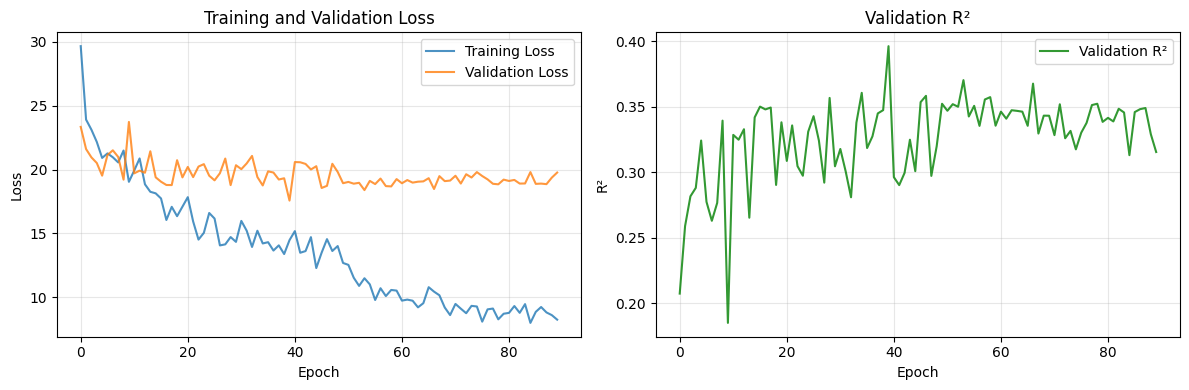

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from typing import Dict, List, Tuple
import time

class MLPRegressor(nn.Module):

    def __init__(self, input_dim: int = 12, hidden_dims: List[int] = [256,128,64],
                 dropout_rate: float = 0.4):
        super(MLPRegressor, self).__init__()

        layers = []
        prev_dim = input_dim

        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze(-1)


class TorchTrainer:

    def __init__(self, model: nn.Module,
                 device: str = None):
        self.model = model
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        self.criterion = nn.MSELoss()

    def prepare_data(self, X: np.ndarray, y: np.ndarray, batch_size: int = 32,
                    shuffle: bool = True) -> DataLoader:

        X_tensor = torch.FloatTensor(X)

        y_tensor = torch.FloatTensor(y)

        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    def train_epoch(self, train_loader: DataLoader, optimizer: optim.Optimizer) -> float:

        self.model.train()
        total_loss = 0.0
        num_batches = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(X_batch)
            loss = self.criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        return total_loss / num_batches

    def validate(self, val_loader: DataLoader) -> Tuple[float, float]:

        self.model.eval()
        total_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                total_loss += loss.item()


                all_preds.extend(outputs.cpu().numpy())

                all_targets.extend(y_batch.cpu().numpy())

        avg_loss = total_loss / len(val_loader)

        metric = r2_score(all_targets, all_preds)

        return avg_loss, metric

    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray, y_val: np.ndarray,
            epochs: int = 300, batch_size: int = 32,
            lr: float = 0.01, weight_decay: float = 1e-5,
            patience: int = 50, verbose: bool = True) -> Dict:


        train_loader = self.prepare_data(X_train, y_train, batch_size, shuffle=True)
        val_loader = self.prepare_data(X_val, y_val, batch_size, shuffle=False)

        optimizer = optim.Adam(self.model.parameters(), lr=lr)#, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)

        history = {
            'train_loss': [],
            'val_loss': [],
            'val_metric': []
        }

        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None

        start_time = time.time()

        for epoch in range(epochs):

            train_loss = self.train_epoch(train_loader, optimizer)
            scheduler.step()

            val_loss, val_metric = self.validate(val_loader)


            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_metric'].append(val_metric)


            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = self.model.state_dict().copy()
            else:
                patience_counter += 1

            if verbose and (epoch + 1) % 10 == 0:
                metric_name = "R²"
                print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | "
                      f"Val Loss: {val_loss:.4f} | Val {metric_name}: {val_metric:.4f}")


            if patience_counter >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}")
                break


        training_time = time.time() - start_time

        if verbose:
            print(f"Training completed in {training_time:.2f} seconds")

        return history

    def predict(self, X: np.ndarray, batch_size: int = 32) -> np.ndarray:

        self.model.eval()
        test_loader = self.prepare_data(X, np.zeros(len(X)), batch_size, shuffle=False)

        predictions = []
        with torch.no_grad():
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(self.device)
                outputs = self.model(X_batch)

                predictions.extend(outputs.cpu().numpy())

        return np.array(predictions)

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> Dict[str, float]:

        predictions = self.predict(X)

        mse = mean_squared_error(y, predictions)
        r2 = r2_score(y, predictions)
        return {"MSE": mse, "R²": r2, "RMSE": np.sqrt(mse)}

def plot_training_history(history: Dict, task_type: str = "regression"):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_loss'], label='Training Loss', alpha=0.8)
    ax1.plot(history['val_loss'], label='Validation Loss', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    metric_name = "R²" if task_type == "regression" else "Accuracy"
    ax2.plot(history['val_metric'], label=f'Validation {metric_name}', color='green', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel(metric_name)
    ax2.set_title(f'Validation {metric_name}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":

    p = 12
    beta = [-1.0, -2.5, 2.8, 0.0, -1.6, 2.0, 0.5, 2.3, 1.5, -1.75, -1.7,1.9]
    generator = SyntheticDataGenerator(p=p, beta=beta, beta0=0.25)
    dataset = generator.create_dataset(n=1000, n_test=300, linear=False)

    print("Training PyTorch models on synthetic data...")


    mlp_model = MLPRegressor(input_dim=p)
    mlp_trainer = TorchTrainer(mlp_model)

    mlp_history = mlp_trainer.fit(
        dataset.X_train, dataset.y_train,
        dataset.X_val, dataset.y_val,
    )

    mlp_results = mlp_trainer.evaluate(dataset.X_test, dataset.y_test)
    print(f"MLP Model Test Results: {mlp_results}")

    plot_training_history(mlp_history, task_type="regression")


In [137]:
###############################################################
###################### Dataset Speichern ######################
###############################################################



linear = False

if linear:
    if os.path.isfile("Synthetic_Data/synth_dataset_linear.npz"):

        data = np.load("Synthetic_Data/synth_dataset_linear.npz")
        dataset = Dataset(
            X_train=data["X_train"],
            y_train=data["y_train"],
            X_val=data["X_val"],
            y_val=data["y_val"],
            X_test=data["X_test"],
            y_test=data["y_test"],
            true_effects=data["true_effects"],
            beta=data["beta"],
        )
    else:
        np.savez("Synthetic_Data/synth_dataset_linear.npz",
             X_train=dataset.X_train,
             y_train=dataset.y_train,
             X_val=dataset.X_val,
             y_val=dataset.y_val,
             X_test=dataset.X_test,
             y_test=dataset.y_test,
             true_effects=dataset.true_effects,
             beta=dataset.beta)

    if os.path.isfile("Models/synth_model_linear.pth"):

        mlp_model = torch.load("Models/synth_model_linear.pth",weights_only=False)
        mlp_model.eval()
    else:
        torch.save(mlp_model,"Models/synth_model_linear.pth")
else:
    if os.path.isfile("Synthetic_Data/synth_dataset.npz"):

        data = np.load("Synthetic_Data/synth_dataset.npz")
        dataset = Dataset(
            X_train=data["X_train"],
            y_train=data["y_train"],
            X_val=data["X_val"],
            y_val=data["y_val"],
            X_test=data["X_test"],
            y_test=data["y_test"],
            true_effects=data["true_effects"],
            beta=data["beta"],
        )
    else:
        np.savez("Synthetic_Data/synth_dataset.npz",
             X_train=dataset.X_train,
             y_train=dataset.y_train,
             X_val=dataset.X_val,
             y_val=dataset.y_val,
             X_test=dataset.X_test,
             y_test=dataset.y_test,
             true_effects=dataset.true_effects,
             beta=dataset.beta)

    if os.path.isfile("Models/synth_model.pth"):

        mlp_model = torch.load("Models/synth_model.pth",weights_only=False)
        mlp_model.eval()
    else:
        torch.save(mlp_model,"Models/synth_model.pth")

In [144]:
model = mlp_model
X_test = dataset.X_test
X_test_tensor = torch.Tensor(X_test)
aa = ApproxAttribution(model)
sal = Saliency(model)
IxG = InputXGradient(model)
Ig = IntegratedGradients(model)

real = dataset.true_effects






def gen_stats_synth(method="Sal",h=0.1,baseline = 'Zero'):

    pearson_list1 = []
    mse_list1 = []
    cosine_list1 = []
    pearson_list2 = []
    mse_list2 = []
    cosine_list2 = []

    if method == "Sal":
        attr = sal.attribute(X_test_tensor).detach()
        approx = aa.grad_approx(X=X_test_tensor,h=h).reshape((300,12))
    elif method == "GxI":
        attr = IxG.attribute(X_test_tensor).detach()
        approx = aa.grad_x_i_approx(X=X_test_tensor,h=h).reshape((300,12))
    elif method == "Int":
        if baseline == "Zero":
            attr = Ig.attribute(X_test_tensor).detach()
            approx = aa.int_grad_approx(X=X_test_tensor,h=h).reshape((300,12))
        elif baseline == "Mean":
            baseline_mean = torch.mean(X_test_tensor, dim=0).unsqueeze(0)  # Mittelwert über alle Samples
            baseline_mean_np = baseline_mean.detach().cpu().numpy().squeeze(0)
            attr = Ig.attribute(X_test_tensor, baselines=baseline_mean).detach()
            approx = aa.int_grad_approx(X=X_test_tensor, h=h, baseline=baseline_mean_np).reshape((300,12))
        else:
            attr = Ig.attribute(X_test_tensor, baselines=baseline).detach()
            approx = aa.int_grad_approx(X=X_test_tensor, h=h, baseline=baseline).reshape((300,12))

    attr_np = attr.detach().cpu().numpy()   # shape (300, 12)

    sample_stds = np.std(attr_np, axis=1)   # std pro Sample
    count = np.sum(sample_stds == 0)
    print("Samples mit konstanter Attribution:", count)
    for i in range(real.shape[0]):

        r = real[i]
        a = attr[i]
        ap = approx[i]



        if np.std(r) == 0:
            continue
        if np.std(a.cpu().numpy()) == 0:
            continue
        if np.std(ap.detach().cpu().numpy()) == 0:
            continue
        # Pearson-Korrelation
        pearson = np.corrcoef(r, a)[0, 1]
        pearson_list1.append(pearson)
        pearson = np.corrcoef(r, ap)[0, 1]
        pearson_list2.append(pearson)

        # MSE
        mse = mean_squared_error(r, a)
        mse_list1.append(mse)
        mse = mean_squared_error(r, ap)
        mse_list2.append(mse)

        # Cosine Similarity
        cos = cosine_similarity(r.reshape(1, -1), a.reshape(1, -1))[0, 0]
        cosine_list1.append(cos)
        cos = cosine_similarity(r.reshape(1, -1), ap.reshape(1, -1))[0, 0]
        cosine_list2.append(cos)

    print("Attribution Mean Pearson Correlation: ", np.nanmean(pearson_list1),np.std(pearson_list1))
    print("Attribution Mean MSE: ", np.mean(mse_list1),np.std(mse_list1))
    print("Attribution Mean Cosine Similarity", np.mean(cosine_list1),np.std(cosine_list1))
    print()
    print("Approximated Mean Pearson Correlation: ", np.nanmean(pearson_list2),np.std(pearson_list2))
    print("Approximated Mean MSE: ", np.mean(mse_list2),np.std(mse_list2))
    print("Approximated Mean Cosine Similarity", np.mean(cosine_list2),np.std(cosine_list2))

gen_stats_synth(h=0.01,method="Sal")
gen_stats_synth(h=0.01,method="GxI")
gen_stats_synth(h=0.01,method="Int",baseline="Zero")


/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


Samples mit konstanter Attribution: 1
Attribution Mean Pearson Correlation:  -0.08257661061474254 0.30206629227965026
Attribution Mean MSE:  7.1457873106910075 5.90082962812955
Attribution Mean Cosine Similarity 0.1417318615322539 0.2849519591458231

Approximated Mean Pearson Correlation:  -0.07927241074455359 0.30495921327500836
Approximated Mean MSE:  7.183515028611518 6.022894461149108
Approximated Mean Cosine Similarity 0.14329453757814978 0.28491740119127806


/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


Samples mit konstanter Attribution: 1
Attribution Mean Pearson Correlation:  0.4700596871621365 0.2529318525175338
Attribution Mean MSE:  5.213131045262227 4.227548997845657
Attribution Mean Cosine Similarity 0.4289771347658074 0.2469502311082749

Approximated Mean Pearson Correlation:  0.4699880541989742 0.25382815322367885
Approximated Mean MSE:  5.231934967093881 4.304988188229286
Approximated Mean Cosine Similarity 0.42894791750213185 0.248234703864098
Samples mit konstanter Attribution: 0
Attribution Mean Pearson Correlation:  0.606528781836122 0.20826682043448982
Attribution Mean MSE:  8.28345509903778 5.698481800387683
Attribution Mean Cosine Similarity 0.5664330378163679 0.20077902439030743

Approximated Mean Pearson Correlation:  0.5485106147756704 0.2321082570375539
Approximated Mean MSE:  3.092712719747251 1.3758303084824801
Approximated Mean Cosine Similarity 0.49535781514976995 0.2290296597403406


/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


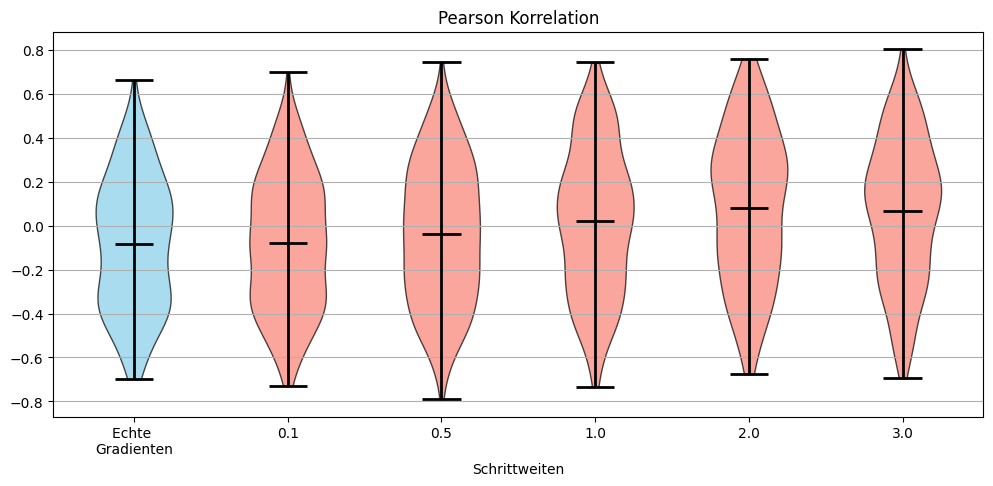

Attribution Mean Pearson Correlation: -0.08257661061474254 (0.30206629227965026)
Attribution Mean MSE: 7.1457873106910075 (5.90082962812955)
Attribution Mean Cosine Similarity 0.1417318615322539 (0.2849519591458231)

Schrittweite: 0.1 Mean Pearson Correlation: -0.07995653170491253 (0.3027029971598244)
Schrittweite: 0.1 Mean MSE: 6.983813099389968 (5.564533456548256)
Schrittweite: 0.1 Mean Cosine Similarity 0.1422917244773285 (0.2877859019924524)

Schrittweite: 0.5 Mean Pearson Correlation: -0.036117414433135674 (0.31633962503330815)
Schrittweite: 0.5 Mean MSE: 6.059172654283724 (3.7275231697103535)
Schrittweite: 0.5 Mean Cosine Similarity 0.17060001216620738 (0.29173064374774393)

Schrittweite: 1 Mean Pearson Correlation: 0.02083604722880316 (0.3289629364517659)
Schrittweite: 1 Mean MSE: 5.077515206596845 (2.2983061089739327)
Schrittweite: 1 Mean Cosine Similarity 0.20299695907307885 (0.2941278353147724)

Schrittweite: 2 Mean Pearson Correlation: 0.08212178483079471 (0.3412679612867324

In [139]:
def step_increment(hs=[0.1,0.5,1,2,3],
                   dataset = dataset,
                   model = mlp_model,
                   method = "Sal",
                   baseline = "Zero",
                   filename= "Sal_schrittweiten_synth.png"):
    X_test = dataset.X_test
    X_test_tensor = torch.Tensor(X_test)

    real = dataset.true_effects

    pearson_list1 = []
    mse_list1 = []
    cosine_list1 = []

    pearson_list2 = []
    mse_list2 = []
    cosine_list2 = []

    aa = ApproxAttribution(model)

    per1= []
    per2= []

    cos1= []
    cos2= []

    mse1= []
    mse2= []

    resattr = []
    resappr = []

    for h in hs:
        if method == "Sal":
            sal = Saliency(model)
            attr = sal.attribute(X_test_tensor).detach()
            approx = aa.grad_approx(X=X_test_tensor,h=h).reshape((300,12))
        elif method == "GxI":
            IxG = InputXGradient(model)
            attr = IxG.attribute(X_test_tensor).detach()
            approx = aa.grad_x_i_approx(X=X_test_tensor,h=h).reshape((300,12))
        elif method == "Int":
            Ig = IntegratedGradients(model)
            if baseline == "Zero":
                baseline_z = torch.zeros_like(X_test_tensor)
                attr = Ig.attribute(X_test_tensor,baselines=baseline_z).detach()
                approx = aa.int_grad_approx(X=X_test_tensor,h=h).reshape((300,12))
            elif baseline == "Mean":
                baseline_mean = torch.mean(X_test_tensor, dim=0).unsqueeze(0)  # Mittelwert über alle Samples
                baseline_mean_np = baseline_mean.detach().cpu().numpy().squeeze(0)
                attr = Ig.attribute(X_test_tensor, baselines=baseline_mean).detach()
                approx = aa.int_grad_approx(X=X_test_tensor, h=h, baseline=baseline_mean_np).reshape((300,12))
            else:
                attr = Ig.attribute(X_test_tensor, baselines=baseline).detach()
                approx = aa.int_grad_approx(X=X_test_tensor, h=h, baseline=baseline).reshape((300,12))
        resattr.append(attr)
        resappr.append(approx)

    for i in range(len(resattr)):
        for j in range(resattr[i].shape[0]):

            r = real[j]
            a = resattr[i][j]
            ap = resappr[i][j]


            if np.std(r) == 0:
                continue
            if np.std(a.cpu().numpy()) == 0:
                continue
            if np.std(ap.detach().cpu().numpy()) == 0:
                continue


            pearson = np.corrcoef(r, a)[0, 1]
            pearson_list1.append(pearson)
            pearson = np.corrcoef(r, ap)[0, 1]
            pearson_list2.append(pearson)


            mse = mean_squared_error(r, a)
            mse_list1.append(mse)
            mse = mean_squared_error(r, ap)
            mse_list2.append(mse)

            cos = cosine_similarity(r.reshape(1, -1), a.reshape(1, -1))[0, 0]
            cosine_list1.append(cos)
            cos = cosine_similarity(r.reshape(1, -1), ap.reshape(1, -1))[0, 0]
            cosine_list2.append(cos)

        per1.append(pearson_list1)
        per2.append(pearson_list2)
        cos1.append(cosine_list1)
        cos2.append(cosine_list2)
        mse1.append(mse_list1)
        mse2.append(mse_list2)

        pearson_list1 = []
        pearson_list2 = []
        cosine_list1 = []
        cosine_list2 = []
        mse_list1 = []
        mse_list2 = []

    datasets = [
        np.ravel(per1[0]),
        np.ravel(per2[0]),
        np.ravel(per2[1]),
        np.ravel(per2[2]),
        np.ravel(per2[3]),
        np.ravel(per2[4])
    ]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

    parts = ax.violinplot(datasets, showmeans=True)


    for i, pc in enumerate(parts['bodies']):
        if i == 0:
            pc.set_facecolor("skyblue")
            pc.set_edgecolor("black")
            pc.set_alpha(0.7)
        else:
            pc.set_facecolor("salmon")
            pc.set_edgecolor("black")
            pc.set_alpha(0.7)

    for key in ['cmins', 'cmaxes', 'cbars', 'cmeans']:
        if key in parts:
            if isinstance(parts[key], list):
                for line in parts[key]:
                    line.set_color("black")
                    line.set_linewidth(2)
            else:
                parts[key].set_color("black")
                parts[key].set_linewidth(2)


    ax.yaxis.grid(True)
    ax.set_xticks([1,2,3,4,5,6], labels=['Echte \nGradienten','0.1','0.5','1.0','2.0','3.0'])
    ax.set_title('Pearson Korrelation')
    ax.set_xlabel('Schrittweiten')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

    print(f"Attribution Mean Pearson Correlation: {np.nanmean(per1[0])} ({np.std(per1[0])})")
    print(f"Attribution Mean MSE: {np.mean(mse1[0])} ({np.std(mse1[0])})")
    print(f"Attribution Mean Cosine Similarity {np.mean(cos1[0])} ({np.std(cos1[0])})")
    print()
    for i in range(len(hs)):
        print(f"Schrittweite: {hs[i]} Mean Pearson Correlation: {np.nanmean(per2[i])} ({np.std(per2[i])})")
        print(f"Schrittweite: {hs[i]} Mean MSE: {np.mean(mse2[i])} ({np.std(mse2[i])})")
        print(f"Schrittweite: {hs[i]} Mean Cosine Similarity {np.mean(cos2[i])} ({np.std(cos2[i])})")
        print()
step_increment()

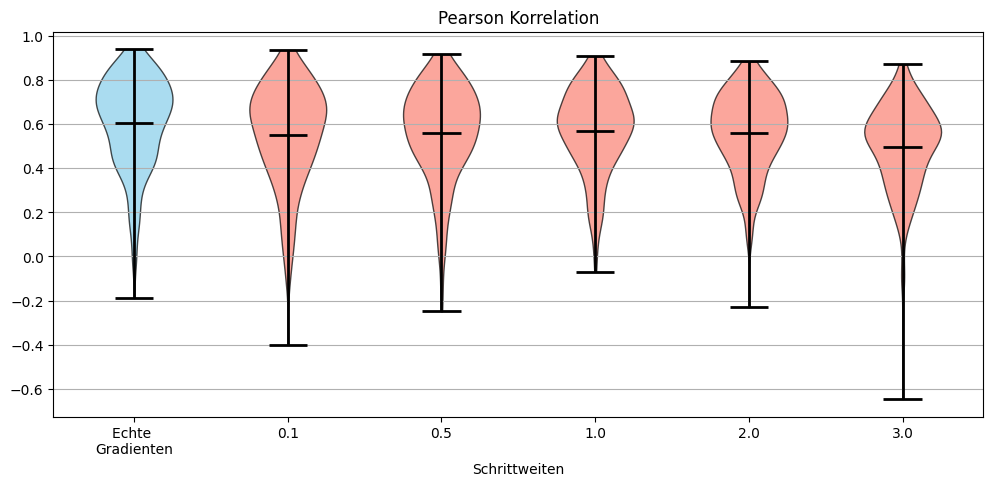

Attribution Mean Pearson Correlation: 0.606528781836122 (0.20826682043448982)
Attribution Mean MSE: 8.28345509903778 (5.698481800387683)
Attribution Mean Cosine Similarity 0.5664330378163679 (0.20077902439030743)

Schrittweite: 0.1 Mean Pearson Correlation: 0.5492986216281194 (0.22998065149046729)
Schrittweite: 0.1 Mean MSE: 3.0657238115485956 (1.330407731939798)
Schrittweite: 0.1 Mean Cosine Similarity 0.4990894245714159 (0.22654401735749158)

Schrittweite: 0.5 Mean Pearson Correlation: 0.559691388418446 (0.21398234389706036)
Schrittweite: 0.5 Mean MSE: 2.90771759007018 (1.1960565511959556)
Schrittweite: 0.5 Mean Cosine Similarity 0.5224092350545245 (0.2108760494107712)

Schrittweite: 1 Mean Pearson Correlation: 0.5697656390981335 (0.1917866860098554)
Schrittweite: 1 Mean MSE: 2.7558173065762785 (1.0740313945277642)
Schrittweite: 1 Mean Cosine Similarity 0.5464071831354766 (0.18821658602338412)

Schrittweite: 2 Mean Pearson Correlation: 0.5608900039260927 (0.18191262753788687)
Schritt

In [140]:
step_increment(method="Int",baseline="Zero",filename="Int_schrittweiten_Zero_synth.png")

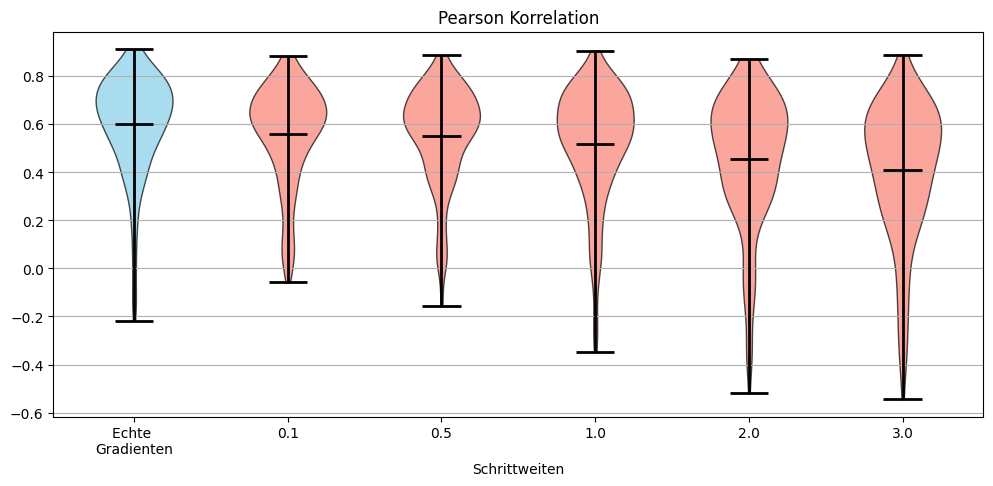

Attribution Mean Pearson Correlation: 0.5991284231420415 (0.20771948428194958)
Attribution Mean MSE: 2.858298653909701 (1.9664252573787229)
Attribution Mean Cosine Similarity 0.5825265057462347 (0.20097011928684114)

Schrittweite: 0.1 Mean Pearson Correlation: 0.5573107210641164 (0.20788095348747412)
Schrittweite: 0.1 Mean MSE: 2.921194750877304 (1.104233935497232)
Schrittweite: 0.1 Mean Cosine Similarity 0.482464141655153 (0.22084303000248834)

Schrittweite: 0.5 Mean Pearson Correlation: 0.5526606816564457 (0.20393063966223304)
Schrittweite: 0.5 Mean MSE: 2.8430610464121995 (0.8755036971299172)
Schrittweite: 0.5 Mean Cosine Similarity 0.48937216734329675 (0.20825708319691041)

Schrittweite: 1 Mean Pearson Correlation: 0.5175718557019185 (0.23762537263693548)
Schrittweite: 1 Mean MSE: 2.8705117102503626 (0.7767192728511159)
Schrittweite: 1 Mean Cosine Similarity 0.46656572461820606 (0.23081461333131248)

Schrittweite: 2 Mean Pearson Correlation: 0.4556325964928035 (0.2717496026658406)


In [141]:
step_increment(method="Int",baseline="Mean",filename="Int_schrittweiten_Mean_synth.png")

/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


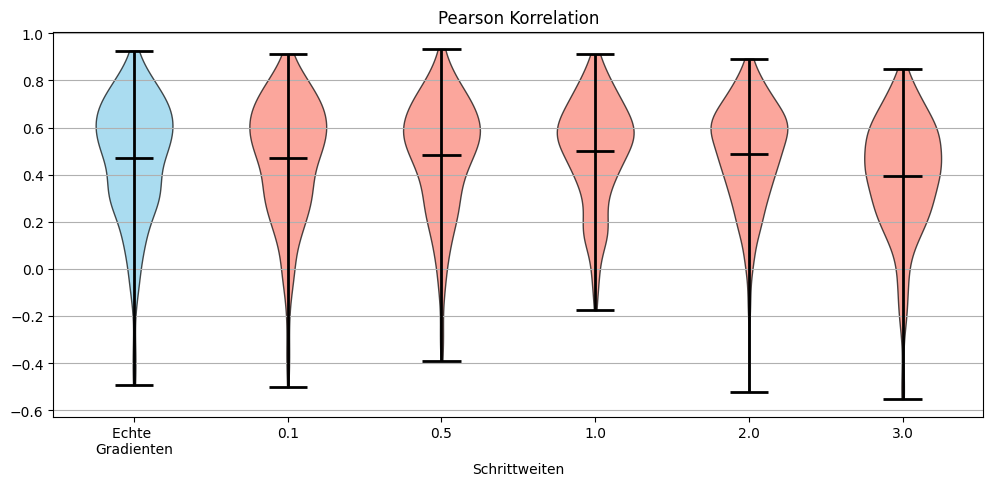

Attribution Mean Pearson Correlation: 0.4700596871621365 (0.2529318525175338)
Attribution Mean MSE: 5.213131045262227 (4.227548997845657)
Attribution Mean Cosine Similarity 0.4289771347658074 (0.2469502311082749)

Schrittweite: 0.1 Mean Pearson Correlation: 0.4698398517937935 (0.25308001718865264)
Schrittweite: 0.1 Mean MSE: 5.139759905585499 (4.259179948897118)
Schrittweite: 0.1 Mean Cosine Similarity 0.43089370396008414 (0.24756431179502106)

Schrittweite: 0.5 Mean Pearson Correlation: 0.4816511726147777 (0.2403614117628933)
Schrittweite: 0.5 Mean MSE: 4.640896531107001 (3.3684811414903506)
Schrittweite: 0.5 Mean Cosine Similarity 0.4532819894509881 (0.23647324490684013)

Schrittweite: 1 Mean Pearson Correlation: 0.4991436742781186 (0.2212092461177995)
Schrittweite: 1 Mean MSE: 4.106690384217109 (2.5396561583044823)
Schrittweite: 1 Mean Cosine Similarity 0.4814330073986295 (0.21665451135940575)

Schrittweite: 2 Mean Pearson Correlation: 0.48966559839912693 (0.2164568805635182)
Schrit

In [142]:
step_increment(method="GxI",filename="GxI_schrittweiten_synth.png")